In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from google.colab import drive
import keras
from keras.callbacks import EarlyStopping

In [ ]:
drive.mount('/content/drive') # Change if needed
denoized_database_path = "" # Write the denoized_database/ path
denoized_augmented_database_path = "" # Write the denoized_database/ path
databases_infos_path = "" # Write a directory path where you are reading and saving .xlsx files with databases informations.

Mounted at /content/drive


In [ ]:
df = pd.read_excel(os.path.join(databases_infos_path, "instances.xlsx"))
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)
df

,ID,BPM,num_channels,sample_width,frame_rate,num_frames,duration
0,f1_0,132,1,2,16000,160000,10
1,f1_1,148,1,2,16000,160000,10
2,f1_2,150,1,2,16000,160000,10
3,f2_0,150,1,2,16000,160000,10
4,f2_1,147,1,2,16000,160000,10
...,...,...,...,...,...,...,...
616,f100_6,125,1,2,16000,160000,10
617,f101_0,150,1,2,16000,160000,10
618,f101_1,152,1,2,16000,160000,10
619,f101_2,151,1,2,16000,160000,10


In [ ]:
df_aumentado = pd.read_excel(os.path.join(databases_infos_path, "instances_augmented.xlsx"), index_col=0)
if "Unnamed: 0" in df_aumentado.columns:
    df_aumentado.drop(columns=["Unnamed: 0"], inplace=True)
df_aumentado

,ID,BPM,num_channels,sample_width,frame_rate,num_frames,duration
0,f1_0,132.0,1,2,16000,160000,10
1,f1_1,148.0,1,2,16000,160000,10
2,f1_2,150.0,1,2,16000,160000,10
4,f1_4,140.0,1,2,16000,160000,10
5,f1_5,149.0,1,2,16000,160000,10
...,...,...,...,...,...,...,...
1140,f101_2,151.0,1,2,16000,160000,10
1141,f101_3,147.0,1,2,16000,160000,10
1142,f101_4,151.0,1,2,16000,160000,10
1143,f101_5,151.5,1,2,16000,160000,10


### Data

In [ ]:
def load_audio_files(dataset_df, audio_dir, sr=16000):

    audio_data = []

    for idx, row in dataset_df.iterrows():
        # Builds the .wav file name -> Example: "f17-1_0_139.wav"
        filename = f"{row['ID']}_{row['BPM']}.wav"
        filepath = os.path.join(audio_dir, filename)

        # Checks if the file exists before loading.
        if not os.path.isfile(filepath):
            print(f"Arquivo não encontrado: {filepath}")
            audio_data.append(None)
            continue

        # Loads the audio with Librosa.
        audio, sr_loaded = librosa.load(filepath, sr=sr)
        audio_data.append(audio)

    # Adds the 'audio_wave' column to the DataFrame.
    dataset_df['audio_wave'] = audio_data

    return dataset_df

In [ ]:
# Loads the audio files into the DataFrame.
df = load_audio_files(df, denoized_database_path)
df

,ID,BPM,num_channels,sample_width,frame_rate,num_frames,duration,audio_wave
0,f1_0,132,1,2,16000,160000,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,f1_1,148,1,2,16000,160000,10,"[-0.0019836426, -0.0020751953, -0.0021972656, ..."
2,f1_2,150,1,2,16000,160000,10,"[0.00018310547, 0.00018310547, 0.00018310547, ..."
3,f2_0,150,1,2,16000,160000,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,f2_1,147,1,2,16000,160000,10,"[0.0034179688, 0.0031433105, 0.0028381348, 0.0..."
...,...,...,...,...,...,...,...,...
616,f100_6,125,1,2,16000,160000,10,"[-3.0517578e-05, -6.1035156e-05, -9.1552734e-0..."
617,f101_0,150,1,2,16000,160000,10,"[6.1035156e-05, 6.1035156e-05, 6.1035156e-05, ..."
618,f101_1,152,1,2,16000,160000,10,"[-6.1035156e-05, -3.0517578e-05, -3.0517578e-0..."
619,f101_2,151,1,2,16000,160000,10,"[0.0032958984, 0.0033569336, 0.0034179688, 0.0..."


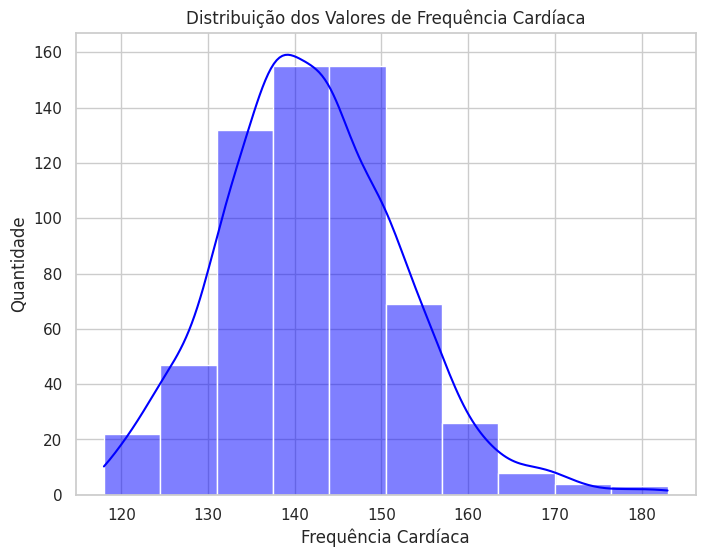

In [ ]:
# Displays the distribution of heart rate frequencies
sns.set(style='whitegrid')

plt.figure(figsize=(8, 6))
sns.histplot(df['BPM'], kde=True, bins=10, color='blue')

plt.title('Distribution of Heart Rate Values')
plt.xlabel('Heart Rate')
plt.ylabel('Count')

plt.show()


In [ ]:
def apply_minmax_scaler(df, column='BPM', new_column=None, feature_range=(0, 1)):
    if new_column is None:
        new_column = column + '_scaled'

    # Creates and fits the scaler
    scaler = MinMaxScaler(feature_range=feature_range)

    # Gets the column values in a 2D format (required for the scaler)
    values = df[column].values.reshape(-1, 1)

    # Applies fit_transform to scale the values
    scaled_values = scaler.fit_transform(values)

    # Creates a new column in the DataFrame with the scaled values
    df[new_column] = scaled_values

    return df, scaler

In [ ]:
df, bpm_scaler = apply_minmax_scaler(df, column='BPM', new_column='BPM_scaled', feature_range=(0, 1))

In [ ]:
df

,ID,BPM,num_channels,sample_width,frame_rate,num_frames,duration,audio_wave,BPM_scaled
0,f1_0,132,1,2,16000,160000,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.215385
1,f1_1,148,1,2,16000,160000,10,"[-0.0019836426, -0.0020751953, -0.0021972656, ...",0.461538
2,f1_2,150,1,2,16000,160000,10,"[0.00018310547, 0.00018310547, 0.00018310547, ...",0.492308
3,f2_0,150,1,2,16000,160000,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.492308
4,f2_1,147,1,2,16000,160000,10,"[0.0034179688, 0.0031433105, 0.0028381348, 0.0...",0.446154
...,...,...,...,...,...,...,...,...,...
616,f100_6,125,1,2,16000,160000,10,"[-3.0517578e-05, -6.1035156e-05, -9.1552734e-0...",0.107692
617,f101_0,150,1,2,16000,160000,10,"[6.1035156e-05, 6.1035156e-05, 6.1035156e-05, ...",0.492308
618,f101_1,152,1,2,16000,160000,10,"[-6.1035156e-05, -3.0517578e-05, -3.0517578e-0...",0.523077
619,f101_2,151,1,2,16000,160000,10,"[0.0032958984, 0.0033569336, 0.0034179688, 0.0...",0.507692


In [ ]:
def apply_mfcc_and_delta_to_df(
    df,
    wave_column='audio_wave',
    result_column='mfcc_features',
    sr=16000,
    n_mfcc=30,
    hop_length=512,
    n_fft=1024,
    delta_order=1,
    remove_first_coef=False,
    normalize_mode='none'
):
    """
    Extracts MFCC (optionally Delta) for each row in the DataFrame, allowing:
      - removing the first coefficient (c0, energy),
      - normalizing all coefficients together,
      - or normalizing the first coefficient separately from the rest.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the column with the audio signal.
    wave_column : str
        Name of the column containing the audio array.
    result_column : str
        Name of the column that will store the extracted features.
    sr : int
        Sampling rate for Librosa (default: 16000).
    n_mfcc : int
        Number of MFCC coefficients (default: 30).
    hop_length : int
        Step size in samples between frames (default: 512).
    n_fft : int
        FFT size (default: 1024).
    delta_order : int
        Order of the delta to be computed. If 0, only MFCC is computed (no delta).
        If > 0, the corresponding derivative is calculated.
    remove_first_coef : bool
        If True, removes the first coefficient (c0) after extraction.
    normalize_mode : str
        Defines how to normalize the features. Options:
          - 'none': no normalization is applied.
          - 'all': normalizes all coefficients at once.
          - 'separate': normalizes the first coefficient separately from the others
            (only makes sense if remove_first_coef=False).

    Returns:
    --------
    df : pandas.DataFrame
        The original DataFrame with the 'result_column' added,
        where each row contains a NumPy array of shape (time, n_features)
        after the specified transformations.
    """

    features_list = []

    for idx, row in df.iterrows():
        audio_wave = row[wave_column]

        # If there is no audio or it is None, store None
        if audio_wave is None:
            features_list.append(None)
            continue

        # Extract MFCC
        mfcc = librosa.feature.mfcc(
            y=audio_wave,
            sr=sr,
            n_mfcc=n_mfcc,
            hop_length=hop_length,
            n_fft=n_fft
        )

        # If delta_order > 0, we calculate the delta
        if delta_order > 0:
            features = librosa.feature.delta(mfcc, order=delta_order)
        else:
            features = mfcc

        # Transpose to (time, n_mfcc)
        features = features.T

        # 1) Remove the first coefficient (c0) if requested
        if remove_first_coef:
            # Remove the first column (index 0), keeping (time, n_mfcc-1)
            features = features[:, 1:]

        # 2) Normalization
        if normalize_mode == 'none':
            # Do nothing
            pass
        elif normalize_mode == 'all':
            # Normalize the entire array as a single block
            # shape (time, n_coefs)
            orig_shape = features.shape
            # Flatten the array to (samples, 1)
            flat_feat = features.reshape(-1, 1)
            # Apply MinMaxScaler
            scaler = MinMaxScaler()
            flat_feat_scaled = scaler.fit_transform(flat_feat)
            # Reshape back to the original shape
            features = flat_feat_scaled.reshape(orig_shape)
        elif normalize_mode == 'separate':
            # This only makes sense if remove_first_coef=False, as we need c0
            # but we will handle the case "remove_first_coef=True" silently
            if (not remove_first_coef) and (features.shape[1] > 1):
                # If c0 is present, separate it
                c0 = features[:, 0].reshape(-1, 1)   # (time, 1)
                rest = features[:, 1:]               # (time, n_mfcc-1)

                # Normalize c0
                scaler_c0 = MinMaxScaler()
                c0_scaled = scaler_c0.fit_transform(c0)

                # Normalize the remaining coefficients
                orig_shape_rest = rest.shape
                flat_rest = rest.reshape(-1, 1)
                scaler_rest = MinMaxScaler()
                rest_scaled = scaler_rest.fit_transform(flat_rest)
                rest_scaled = rest_scaled.reshape(orig_shape_rest)

                # Concatenate back
                features = np.concatenate([c0_scaled, rest_scaled], axis=1)
            else:
                # If remove_first_coef=True or there is not enough first coefficient,
                # it falls back to total normalization or simply does not normalize.
                # For example, we normalize everything using "all" to avoid unexpected behavior.
                orig_shape = features.shape
                flat_feat = features.reshape(-1, 1)
                scaler = MinMaxScaler()
                flat_feat_scaled = scaler.fit_transform(flat_feat)
                features = flat_feat_scaled.reshape(orig_shape)
        else:
            raise ValueError(f"Invalid option for normalize_mode: {normalize_mode}")

        features_list.append(features)

    # Adds the features column to the DataFrame
    df[result_column] = features_list

    return df

Why invert (frames in rows)?
In practice, many machine learning libraries (such as scikit-learn or TensorFlow) prefer frames as the first dimension (i.e., frames × n_mfcc). This is because each frame is typically treated as a "sample" for training, and each MFCC coefficient as a feature. This inversion makes the format compatible with that approach.

| delta_order | normalize_mode | remove_first_coef |
|-------|---------------|--------|
| 0     | separate      | FALSE  |
| 0     | all           | FALSE  |
| 1     | separate      | FALSE  |
| 1     | all           | FALSE  |
| 2     | separate      | FALSE  |
| 2     | all           | FALSE  |
| 0     | all           | TRUE   |
| 1     | all           | TRUE   |
| 2     | all           | TRUE   |


In [ ]:
df = apply_mfcc_and_delta_to_df(
    df,
    wave_column='audio_wave',
    result_column='mfcc_features',
    n_mfcc=30,
    delta_order=1,
    remove_first_coef=False,
    normalize_mode='all'
)

In [ ]:
def plot_mfcc_range(df, feature_column='mfcc_features', sr=16000, start_idx=0, end_idx=5):
    """
    Plots a range of MFCCs from a DataFrame based on the provided indices.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the column with MFCCs (NumPy array or matrix).
    feature_column : str
        Name of the column in the DataFrame that contains the MFCCs.
    sr : int
        Sampling rate used to compute the MFCCs.
    start_idx : int
        Starting index (inclusive) for the range of MFCCs to be plotted.
    end_idx : int
        Ending index (exclusive) for the range of MFCCs to be plotted.

    Returns:
    --------
    None
    """
    # Check if the indices are valid
    if start_idx < 0 or end_idx > len(df) or start_idx >= end_idx:
        raise ValueError("The provided indices are invalid or out of the DataFrame range.")

    # Calculate the number of plots to display
    num_plots = end_idx - start_idx

    # Set up the subplot grid
    fig, axes = plt.subplots(nrows=num_plots, figsize=(10, 4 * num_plots))

    # If there is only one plot, adjust it to work without an array axis
    if num_plots == 1:
        axes = [axes]

    # Iterate over the index range and plot each MFCC
    for i, idx in enumerate(range(start_idx, end_idx)):
        mfcc = df[feature_column].iloc[idx]  # Get the MFCCs for the corresponding row
        ax = axes[i]

        # Display the MFCCs in the subplot
        img = librosa.display.specshow(mfcc.T, sr=sr, x_axis='time', y_axis='mel', ax=ax)
        ax.set_title(f'MFCC - Index {idx}')
        fig.colorbar(img, ax=ax, format='%+2.0f dB')

    # Adjust the layout and show the plots
    plt.tight_layout()
    plt.show()

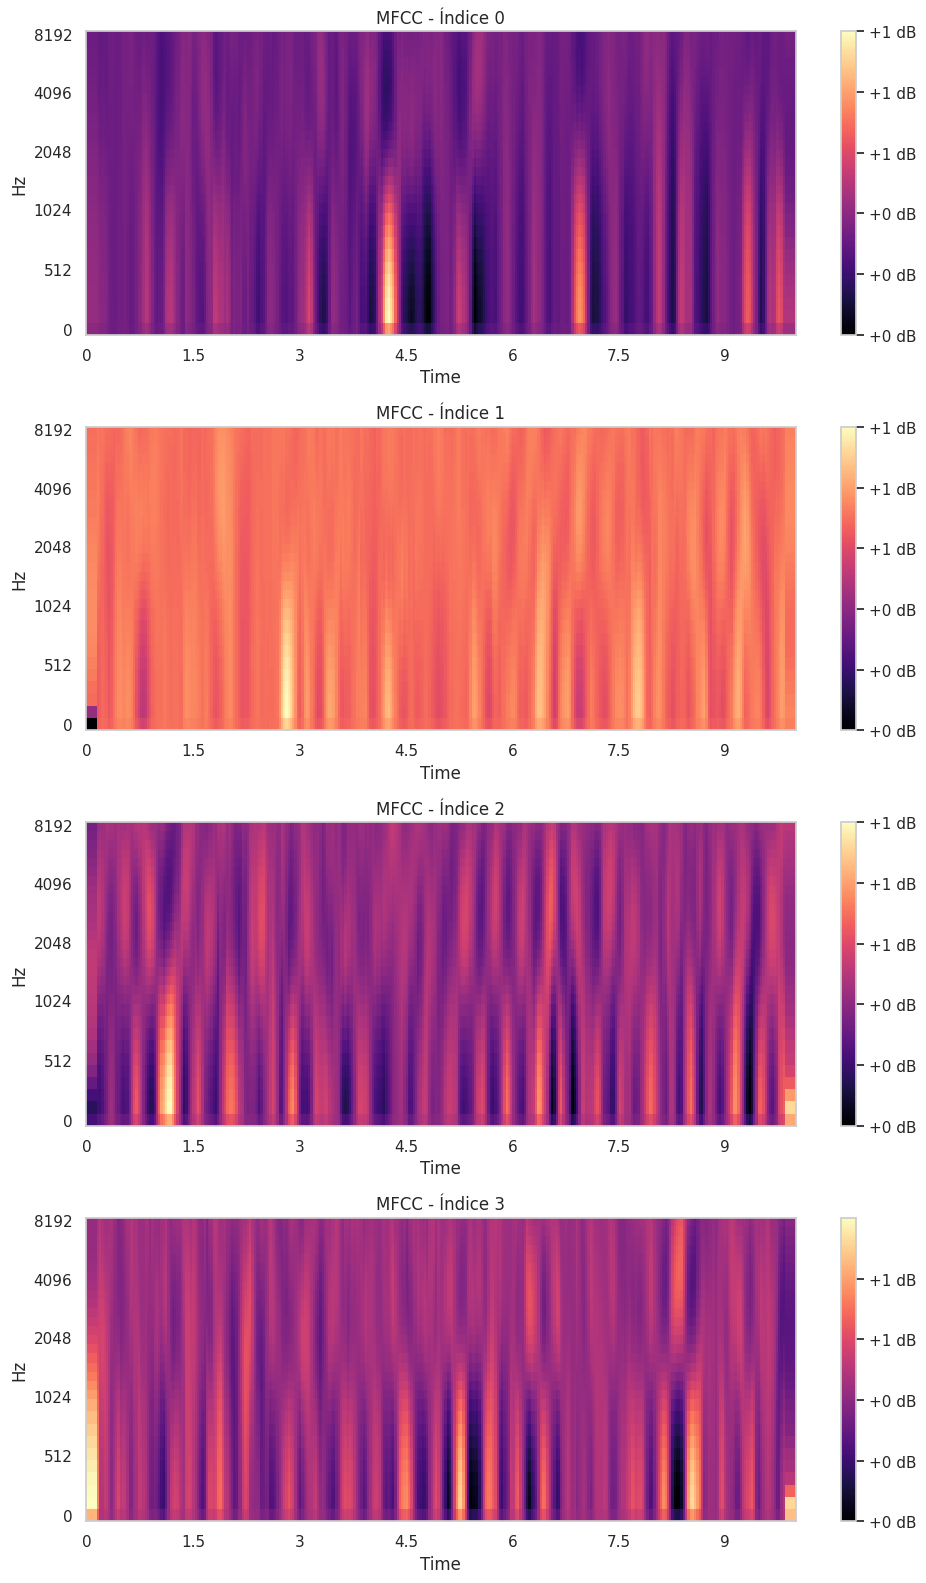

In [ ]:
plot_mfcc_range(df, feature_column='mfcc_features', sr=16000, start_idx=0, end_idx=4)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold

def split_train_test_kfold(
    df,
    patient_column='ID',
    feature_column='mfcc_features',
    label_column='BPM_scaled',
    train_ratio=0.8,
    n_splits=5,
    random_state=42
):
    """
    1) Splits the DataFrame into training (80%) and testing (20%) based on patients.
    2) Within the training set, performs k-fold cross-validation (GroupKFold)
       to generate training and validation subsets (folds).
    3) Returns the test arrays and a list of folds.
       Each fold contains: (X_train_fold, y_train_fold, X_val_fold, y_val_fold).

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame that must contain at least:
         - patient_column (e.g., 'ID') to identify the patient.
         - feature_column (e.g., 'mfcc_features') with arrays (time, n_features).
         - label_column (e.g., 'BPM_scaled') with the label (e.g., BPM).
    patient_column : str
        Name of the column that uniquely identifies the patient.
    feature_column : str
        Name of the column containing the feature array.
    label_column : str
        Name of the column with the label.
    train_ratio : float
        Percentage of patients assigned to the training set (default: 80%).
    n_splits : int
        Number of folds for GroupKFold within the training set.
    random_state : int
        Seed for reproducibility in patient splitting.

    Returns:
    --------
    folds : list
        List of size n_splits. Each item is a tuple:
            (X_train_fold, y_train_fold, X_val_fold, y_val_fold)
        to be used in cross-validation.
    (X_test, y_test) : tuple
        Arrays for the test set (20% of patients),
        for final evaluation.
    """

    # 1) Identify patients and split into train/test
    unique_patients = df[patient_column].unique()
    unique_patients = list(unique_patients)

    # Shuffle the list of patients
    rng = np.random.default_rng(seed=random_state)
    rng.shuffle(unique_patients)

    n_total = len(unique_patients)
    n_train = int(train_ratio * n_total)
    train_patients = unique_patients[:n_train]
    test_patients = unique_patients[n_train:]

    # Subset DataFrame
    df_train = df[df[patient_column].isin(train_patients)]
    df_test  = df[df[patient_column].isin(test_patients)]

    # 2) Convert DF -> arrays X, y
    def df_to_Xy(subdf):
        X_list = []
        y_list = []
        for _, row in subdf.iterrows():
            feats = row[feature_column]  # array (time, n_features)
            label = row[label_column]
            X_list.append(feats)
            y_list.append(label)
        X = np.stack(X_list, axis=0)  # (N, time, n_features)
        y = np.array(y_list, dtype=float)
        return X, y

    X_train_all, y_train_all = df_to_Xy(df_train)
    X_test, y_test = df_to_Xy(df_test)

    # 3) Cross-Validation (GroupKFold) just on the training set
    groups_train = df_train[patient_column].values
    gkf = GroupKFold(n_splits=n_splits)

    folds = []
    for fold_idx, (tr_idx, val_idx) in enumerate(gkf.split(X_train_all, y_train_all, groups=groups_train)):
        X_tr_fold, X_val_fold = X_train_all[tr_idx], X_train_all[val_idx]
        y_tr_fold, y_val_fold = y_train_all[tr_idx], y_train_all[val_idx]

        folds.append((X_tr_fold, y_tr_fold, X_val_fold, y_val_fold))

    return folds, (X_test, y_test)


In [ ]:
folds, (X_test, y_test) = split_train_test_kfold(
    df,
    patient_column='ID',
    feature_column='mfcc_features',
    label_column='BPM_scaled',
    train_ratio=0.8,
    n_splits=5,
    random_state=42
)

# folds is a list with 5 elements (if n_splits=5)
# Each element:
#   (X_tr_fold, y_tr_fold, X_val_fold, y_val_fold)

print("Numer of folds:", len(folds))
for i, (X_tr_fold, y_tr_fold, X_val_fold, y_val_fold) in enumerate(folds, start=1):
    print(f"Fold {i} -> Train: {X_tr_fold.shape}, Val: {X_val_fold.shape}")

print("Final test:", X_test.shape)

Número de folds: 5
Fold 1 -> Treino: (396, 313, 30), Val: (100, 313, 30)
Fold 2 -> Treino: (397, 313, 30), Val: (99, 313, 30)
Fold 3 -> Treino: (397, 313, 30), Val: (99, 313, 30)
Fold 4 -> Treino: (397, 313, 30), Val: (99, 313, 30)
Fold 5 -> Treino: (397, 313, 30), Val: (99, 313, 30)
Teste final: (125, 313, 30)


### Modelo

In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(1, activation="sigmoid", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)



In [ ]:
def train_kfold_and_log(
    folds,
    X_test=None,
    y_test=None,
    scaler=None,
    model_save_path="best_model.keras",
    epochs=100,
    batch_size=32
):
    """
    Performs k-fold training, stores logs for each epoch in a DataFrame,
    saves only the best global model (lowest val_loss), and if X_test, y_test, and scaler are provided,
    evaluates on the test set in the original scale at the end of each fold, storing metrics (MAE, MSE, RMSE, R², std).

    Parameters:
    -----------
    folds : list
        List of (X_tr_fold, y_tr_fold, X_val_fold, y_val_fold).
    X_test, y_test : np.ndarray or None
        **Scaled** global test set (same scaler used in training).
        If None, test metrics are not calculated.
    scaler : scaling object (MinMaxScaler, StandardScaler, etc.) or None
        If provided, it is used to revert the scale of y_test and predictions before calculating metrics.
    model_save_path : str
        Path to save the best model (based on val_loss).
    epochs : int
        Number of training epochs per fold.
    batch_size : int
        Batch size for training.

    Returns:
    --------
    history_df : pd.DataFrame
        DataFrame with training logs for each fold and each epoch:
        columns: [fold, epoch, loss, mae, val_loss, val_mae].
    test_metrics_df : pd.DataFrame
        DataFrame with test metrics for each fold (if X_test, y_test are provided):
        columns: [fold, test_mae, test_mse, test_rmse, test_r2, test_std].
    """
    history_rows = []
    test_rows = []

    best_val_loss = np.inf
    best_model_fold = None
    best_model_weights = None  # Let's store the weights of the best model in memory.

    for fold_idx, (X_tr_fold, y_tr_fold, X_val_fold, y_val_fold) in enumerate(folds, start=1):
        print(f"\n=== Treinando Fold {fold_idx}/{len(folds)} ===")

        # 1) Build and compile model
        input_shape = (X_tr_fold.shape[1], X_tr_fold.shape[2])  # (time, n_features)
        model = build_model(input_shape)
        model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mean_absolute_error'])

        # 2) Define callbacks, EarlyStopping (without ModelCheckpoint para cada fold)
        early_cb = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        # 3) Train
        history = model.fit(
            X_tr_fold, y_tr_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[early_cb]
        )

        # 4) Store logs from each epoch in a DataFrame
        hist_dict = history.history
        n_epochs = len(hist_dict['loss'])  # How many epoch it really ran
        for ep in range(n_epochs):
            row = {
                'fold': fold_idx,
                'epoch': ep + 1,
                'loss': hist_dict['loss'][ep],
                'mae': hist_dict['mean_absolute_error'][ep],
            }
            # Verifify if have val_loss, val_mean_absolute_error
            if 'val_loss' in hist_dict:
                row['val_loss'] = hist_dict['val_loss'][ep]
            if 'val_mean_absolute_error' in hist_dict:
                row['val_mae'] = hist_dict['val_mean_absolute_error'][ep]

            history_rows.append(row)

        # 5) Evaluate on the validation set to check if it is the best
        val_loss, val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        print(f"Fold {fold_idx} - val_loss = {val_loss:.4f}, val_mae = {val_mae:.4f}")

        # If it is the best global fold, we store the weights in memory
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_fold = fold_idx
            best_model_weights = model.get_weights()  # Sale the weights
            print(f">>> [Melhor Fold até agora: {fold_idx}] val_loss = {val_loss:.4f} <<<")

        # 6) If we have test data, we also evaluate it
        #    But now we revert the scale (y_test and predictions) to compute metrics in the original scale
        if (X_test is not None) and (y_test is not None):
            y_pred_scaled = model.predict(X_test)  # Prediction on the scaled test set

            # Reverse scaling if a scaler is provided
            if scaler is not None:
                # Ensure 2D shape (N,1)
                if len(y_test.shape) == 1:
                    y_test_2d = y_test.reshape(-1, 1)
                else:
                    y_test_2d = y_test

                if len(y_pred_scaled.shape) == 1:
                    y_pred_scaled = y_pred_scaled.reshape(-1, 1)

                y_test_original = scaler.inverse_transform(y_test_2d)
                y_pred_original = scaler.inverse_transform(y_pred_scaled)
            else:
                # If no scaler is provided, assume it is already in the original scale
                y_test_original = y_test
                y_pred_original = y_pred_scaled

            # Calculate metrics
            mae_ = mean_absolute_error(y_test_original, y_pred_original)
            mse_ = mean_squared_error(y_test_original, y_pred_original)
            rmse_ = np.sqrt(mse_)
            r2_  = r2_score(y_test_original, y_pred_original)
            errors = y_test_original.flatten() - y_pred_original.flatten()
            std_ = np.std(errors)

            test_rows.append({
                'fold': fold_idx,
                'test_mae': mae_,
                'test_mse': mse_,
                'test_rmse': rmse_,
                'test_r2': r2_,
                'test_std': std_,
            })

    # 7) Convert training logs (all epochs) into a DataFrame
    history_df = pd.DataFrame(history_rows)

    # 8) Convert test metrics (if available) into a DataFrame
    test_metrics_df = pd.DataFrame(test_rows)

    print("\nTreinamento k-fold finalizado.")
    print(f"Melhor fold global: {best_model_fold} com val_loss = {best_val_loss:.4f}")

    # 9) Save the best global model
    if best_model_weights is not None:
        # Rebuild the model and set the best weights
        # (we could also keep the "model" from the best fold, but this approach is safer)
        X_any_fold, _, _, _ = folds[0]  # Get the shape from the first fold
        input_shape_any = (X_any_fold.shape[1], X_any_fold.shape[2])
        best_model = build_model(input_shape_any)
        best_model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mean_absolute_error'])
        best_model.set_weights(best_model_weights)

        best_model.save(model_save_path)
        print(f"Best global model saved in: {model_save_path}")

    return history_df, test_metrics_df

In [ ]:
model_save_path = os.path.join(databases_infos_path, "best_model.keras")

In [ ]:
history_df, test_metrics_df = train_kfold_and_log(
    folds=folds,
    X_test=X_test,
    y_test=y_test,
    scaler=bpm_scaler,
    model_save_path=model_save_path,
    epochs=100,
    batch_size=32
)


=== Treinando Fold 1/5 ===
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - loss: 0.0310 - mean_absolute_error: 0.1393 - val_loss: 0.0258 - val_mean_absolute_error: 0.1284
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0265 - mean_absolute_error: 0.1269 - val_loss: 0.0261 - val_mean_absolute_error: 0.1337
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0249 - mean_absolute_error: 0.1221 - val_loss: 0.0259 - val_mean_absolute_error: 0.1332
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0256 - mean_absolute_error: 0.1242 - val_loss: 0.0260 - val_mean_absolute_error: 0.1338
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0282 - mean_absolute_error: 0.1331 - val_loss: 0.0249 - val_mean_absolute_error: 0.1279
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0282 - mean_absolute_error: 0.1288 - val_loss: 0.0252 - val_mean_absolute_error: 0.1256
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0275 -

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step

=== Treinando Fold 4/5 ===
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - loss: 0.0373 - mean_absolute_error: 0.1515 - val_loss: 0.0337 - val_mean_absolute_error: 0.1407
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0292 - mean_absolute_error: 0.1329 - val_loss: 0.0307 - val_mean_absolute_error: 0.1354
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0277 - mean_absolute_error: 0.1294 - val_loss: 0.0279 - val_mean_absolute_error: 0.1303
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0269 - mean_absolute_error: 0.1278 - val_loss: 0.0266 - val_mean_absolute_error: 0.1273
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0268 - mean_absolute_error: 0.1303 - val_loss: 0.0263 - val_mean_absolute_error: 0.1265
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0243 - mean_absolute_error: 0.1235 - val_loss: 0.0290 - val_mean_absolute_error: 0.1321
Epoch 7/100
13/13 ━━━━━━━━━━━━━

### History

In [ ]:
print(history_df.head())

   fold  epoch      loss       mae  val_loss   val_mae
0     1      1  0.028905  0.133199  0.025834  0.128439
1     1      2  0.027832  0.130397  0.026112  0.133689
2     1      3  0.026232  0.126630  0.025941  0.133202
3     1      4  0.026164  0.125843  0.026032  0.133793
4     1      5  0.026140  0.126734  0.024858  0.127864


In [ ]:
print("\n=== Test Metrics per Fold ===")
print(test_metrics_df.to_string(index=False))


=== Métricas de Teste por Fold ===
 fold  test_mae  test_mse  test_rmse  test_r2  test_std
    1  4.585088 36.587594   6.048768 0.628863  6.024346
    2  4.621620 38.558342   6.209536 0.608872  6.208565
    3  4.543181 35.831934   5.985978 0.636528  5.893434
    4  4.585203 35.305194   5.941817 0.641871  5.938482
    5  4.390507 35.211233   5.933905 0.642824  5.918745


In [ ]:
def plot_training_curves(history_df, main_title="Training"):
    """
    Plots the Loss and MAE curves (train and validation) for each fold.
    Each fold generates a separate plot, with the title being 'main_title' + 'Fold X'.

    Parameters:
    -----------
    history_df : pandas.DataFrame
        DataFrame with the following columns:
          - 'fold': which fold it refers to (int)
          - 'epoch': epoch number (int)
          - 'loss': training loss (float)
          - 'val_loss': validation loss (float), if available
          - 'mae': mean absolute error for training (float)
          - 'val_mae': mean absolute error for validation (float), if available
    main_title : str
        Base title for the plots.
    """

    # Identify unique folds in the DataFrame
    unique_folds = sorted(history_df['fold'].unique())

    for fold_number in unique_folds:
        # Select the rows corresponding to the current fold
        fold_data = history_df[history_df['fold'] == fold_number]

        # Create a figure with two subplots (Loss and MAE)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

        # -- SUBPLOT 1: LOSS --
        axes[0].plot(fold_data['epoch'], fold_data['loss'], label='Train Loss', marker='o')
        if 'val_loss' in fold_data.columns:
            axes[0].plot(fold_data['epoch'], fold_data['val_loss'], label='Val Loss', marker='s')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].set_title('Loss Evolution')

        # -- SUBPLOT 2: MAE --
        axes[1].plot(fold_data['epoch'], fold_data['mae'], label='Train MAE', marker='o', color='orange')
        if 'val_mae' in fold_data.columns:
            axes[1].plot(fold_data['epoch'], fold_data['val_mae'], label='Val MAE', marker='s', color='red')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('MAE')
        axes[1].legend()
        axes[1].set_title('MAE Evolution')

        # Adjust spacing and set the overall title (fold + main title)
        fig.suptitle(f"{main_title} - Fold {fold_number}", fontsize=16)
        plt.tight_layout()
        plt.show()

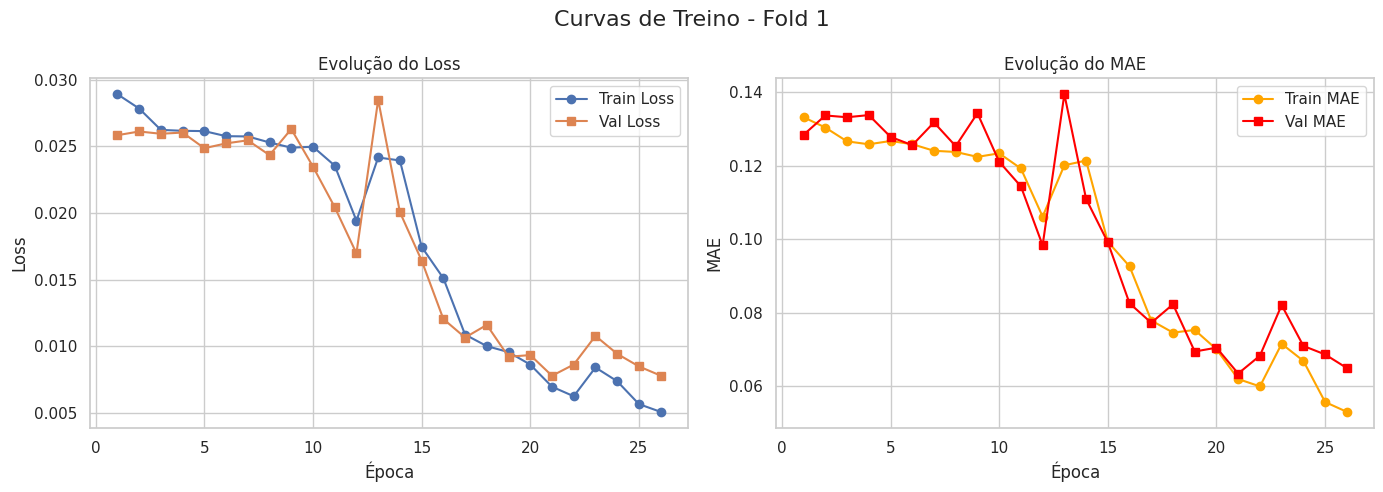

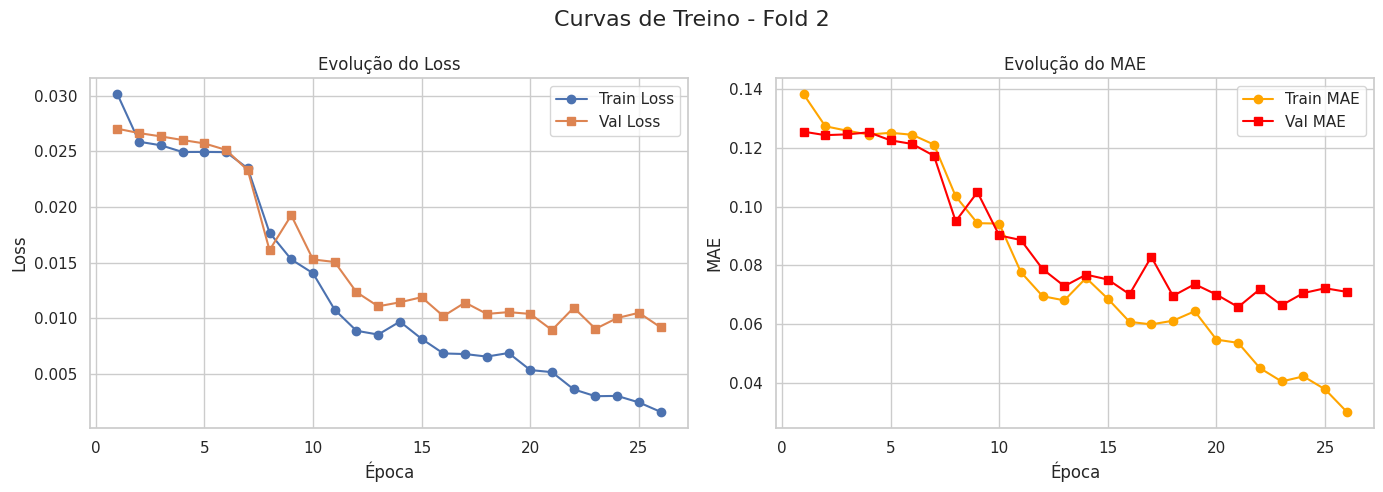

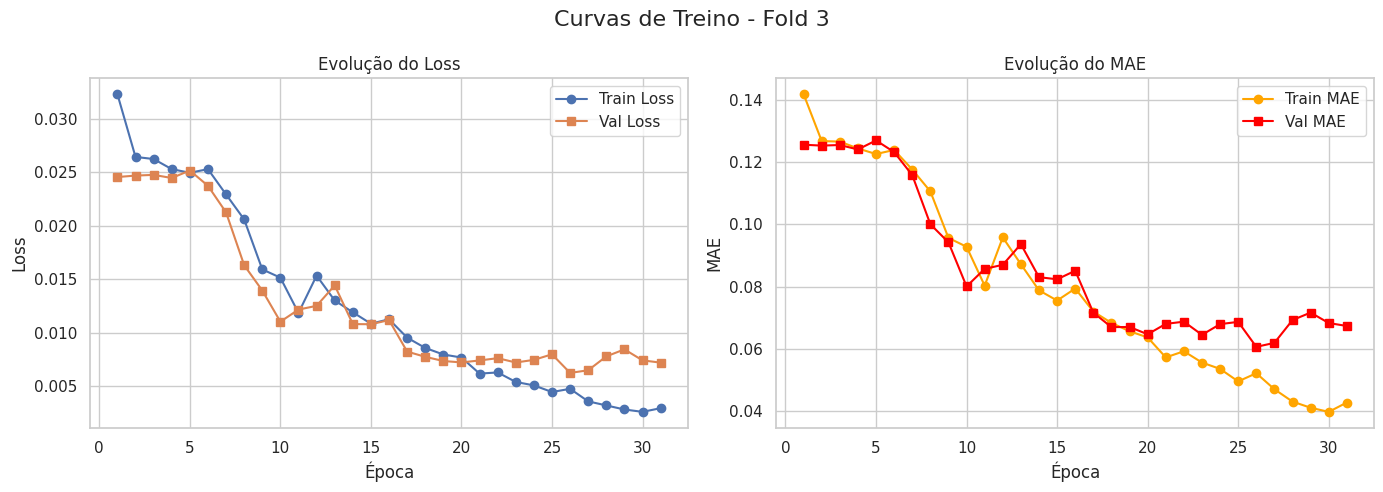

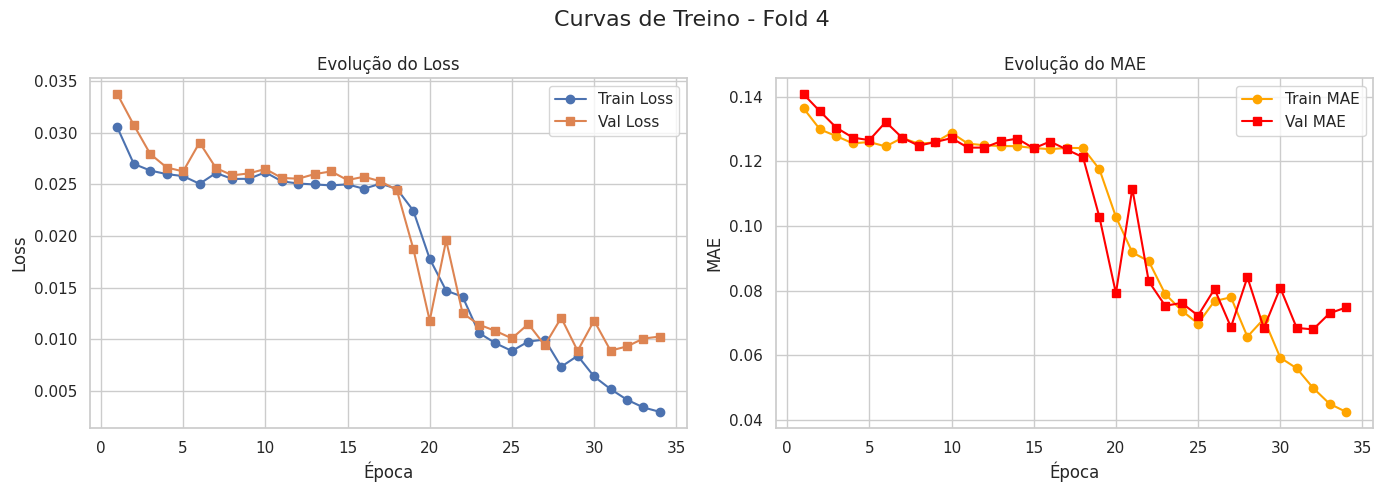

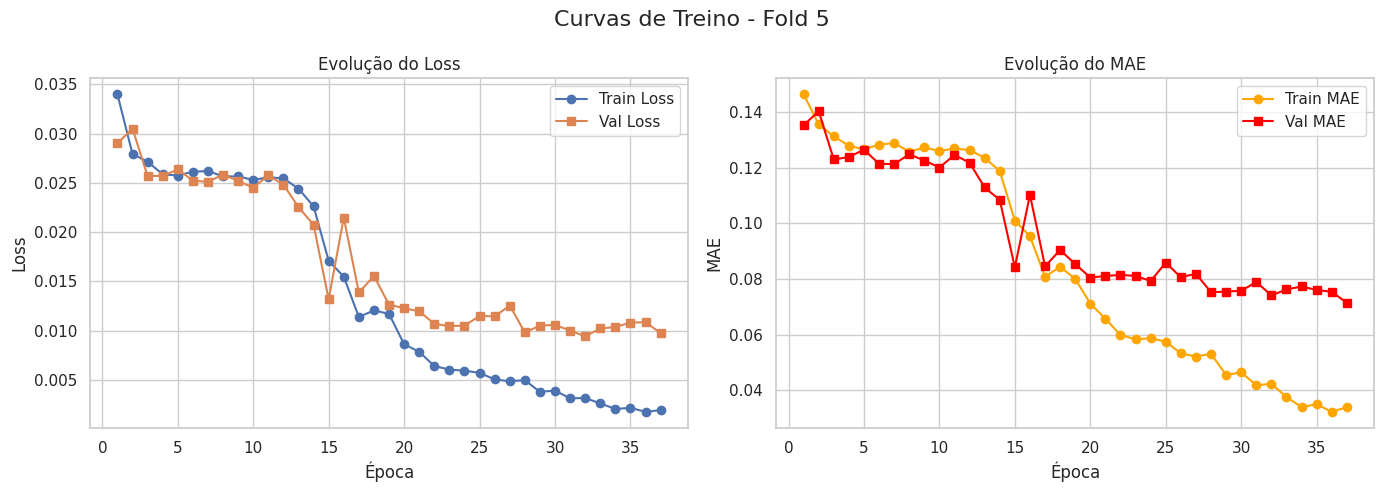

In [ ]:
plot_training_curves(history_df, main_title="Train Curves")